# Proyecto de Predicción de Rotación de Clientes de Beta Bank

### Índice del proyecto
1. **Carga de librerías**
2. **Carga de los datos**
3. **Preparación de los datos**
4. **Investigación inicial del equilibrio de clases**
5. **Entrenamiento del modelo inicial**
6. **Corrección del desequilibrio de clases**
7. **Optimización del modelo**
8. **Evaluación del modelo en el conjunto de prueba**
9. **Conclusiones**

## 1. Carga de librerías

In [1]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score, roc_auc_score, confusion_matrix, classification_report
from sklearn.utils import resample


## 2. Carga de los datos

In [2]:
data = pd.read_csv("/datasets/Churn.csv")
data.head()


,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2.0,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1.0,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8.0,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1.0,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2.0,125510.82,1,1,1,79084.10,0


## 3. Preparación de los datos

In [3]:

# Sección 3: Preparación de los datos

# Eliminar filas con valores nulos
data_cleaned = data.dropna()

# Eliminación de columnas irrelevantes
data_cleaned = data_cleaned.drop(columns=['RowNumber', 'CustomerId', 'Surname'])

# Convertir variables categóricas a numéricas
data_cleaned = pd.get_dummies(data_cleaned, drop_first=True)

# Separar las características (features) y el objetivo (target)
X = data_cleaned.drop(columns='Exited')
y = data_cleaned['Exited']

# Escalado de características
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Separar los datos en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# Verificar la estructura de los datos
X_train.shape, X_test.shape, y_train.shape, y_test.shape


((7272, 11), (1819, 11), (7272,), (1819,))

## 4. Investigación inicial del equilibrio de clases

C:\Users\mm131\AppData\Local\Temp\ipykernel_32808\385692015.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=class_distribution.index, y=class_distribution.values, palette='viridis')


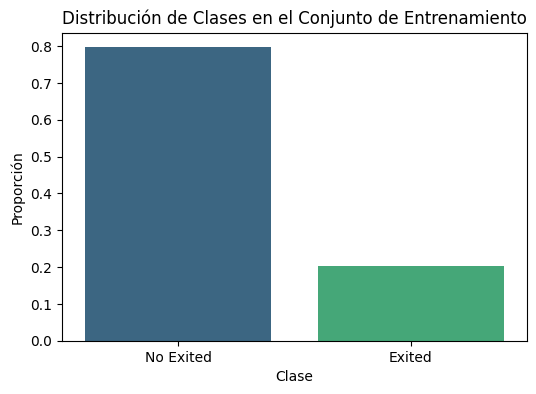

Exited
0    0.79648
1    0.20352
Name: proportion, dtype: float64

In [4]:

# Verificar el equilibrio de clases en el conjunto de entrenamiento
class_distribution = y_train.value_counts(normalize=True)

# Visualizar el equilibrio de clases
plt.figure(figsize=(6, 4))
sns.barplot(x=class_distribution.index, y=class_distribution.values, palette='viridis')
plt.title('Distribución de Clases en el Conjunto de Entrenamiento')
plt.xlabel('Clase')
plt.ylabel('Proporción')
plt.xticks([0, 1], labels=['No Exited', 'Exited'])
plt.show()

class_distribution


## 5. Entrenamiento del modelo inicial

In [5]:

# Entrenar un modelo de regresión logística
log_reg = LogisticRegression(random_state=42)
log_reg.fit(X_train, y_train)

# Predicción en el conjunto de prueba
y_pred_initial = log_reg.predict(X_test)

# Evaluación del modelo
f1_initial = f1_score(y_test, y_pred_initial)
auc_roc_initial = roc_auc_score(y_test, log_reg.predict_proba(X_test)[:, 1])

print(f'F1 inicial: {f1_initial:.4f}')
print(f'AUC-ROC inicial: {auc_roc_initial:.4f}')


F1 inicial: 0.3189
AUC-ROC inicial: 0.7457


## 6. Corrección del desequilibrio de clases

In [6]:

# Unir X_train y y_train para realizar resampling
train_data = pd.DataFrame(X_train, columns=X.columns)
train_data['Exited'] = y_train.values

# Submuestreo de la clase mayoritaria
train_majority = train_data[train_data.Exited == 0]
train_minority = train_data[train_data.Exited == 1]

# Submuestreo
train_majority_downsampled = resample(train_majority, replace=False, n_samples=len(train_minority), random_state=42)
train_downsampled = pd.concat([train_majority_downsampled, train_minority])

# Sobremuestreo
train_minority_upsampled = resample(train_minority, replace=True, n_samples=len(train_majority), random_state=42)
train_upsampled = pd.concat([train_majority, train_minority_upsampled])

# Separar en X e y después de resampling
X_train_down = train_downsampled.drop(columns='Exited')
y_train_down = train_downsampled['Exited']

X_train_up = train_upsampled.drop(columns='Exited')
y_train_up = train_upsampled['Exited']


## 7. Optimización del modelo

In [7]:

# Entrenar modelo con submuestreo
rf_down = RandomForestClassifier(random_state=42)
rf_down.fit(X_train_down, y_train_down)

# Evaluación con submuestreo
y_pred_rf_down = rf_down.predict(X_test)
f1_rf_down = f1_score(y_test, y_pred_rf_down)
auc_roc_rf_down = roc_auc_score(y_test, rf_down.predict_proba(X_test)[:, 1])

# Entrenar modelo con sobremuestreo
rf_up = RandomForestClassifier(random_state=42)
rf_up.fit(X_train_up, y_train_up)

# Evaluación con sobremuestreo
y_pred_rf_up = rf_up.predict(X_test)
f1_rf_up = f1_score(y_test, y_pred_rf_up)
auc_roc_rf_up = roc_auc_score(y_test, rf_up.predict_proba(X_test)[:, 1])

print(f'F1 con submuestreo: {f1_rf_down:.4f}')
print(f'AUC-ROC con submuestreo: {auc_roc_rf_down:.4f}')
print(f'F1 con sobremuestreo: {f1_rf_up:.4f}')
print(f'AUC-ROC con sobremuestreo: {auc_roc_rf_up:.4f}')


C:\Users\mm131\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
C:\Users\mm131\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


F1 con submuestreo: 0.5813
AUC-ROC con submuestreo: 0.8460
F1 con sobremuestreo: 0.5758
AUC-ROC con sobremuestreo: 0.8368


C:\Users\mm131\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
C:\Users\mm131\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


## 8. Evaluación del modelo en el conjunto de prueba

In [8]:

# Selección del mejor modelo (supongamos que es el modelo con sobremuestreo)
final_model = rf_up
y_pred_final = final_model.predict(X_test)

# Evaluar el modelo final
f1_final = f1_score(y_test, y_pred_final)
auc_roc_final = roc_auc_score(y_test, final_model.predict_proba(X_test)[:, 1])

print(f'F1 final: {f1_final:.4f}')
print(f'AUC-ROC final: {auc_roc_final:.4f}')


F1 final: 0.5758
AUC-ROC final: 0.8368


C:\Users\mm131\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
C:\Users\mm131\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
